## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [11]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024
MOMENTUM =0.95

In [12]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]


"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.1]
redice_lr_patient = [20,10,5]

In [13]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor= reduce_factor,
                                  min_lr=1e-12,
                                  monitor="val_loss",
                                  patience=reduce_patient,
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W1109 21:06:21.505956  4120 deprecation_wrapper.py:119] From C:\Users\HAO\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 20


W1109 21:06:21.780246  4120 deprecation_wrapper.py:119] From C:\Users\HAO\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1109 21:06:21.801232  4120 deprecation_wrapper.py:119] From C:\Users\HAO\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

W1109 21:06:22.050361  4120 deprecation.py:323] From C:\Users\HAO\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 264us/step - loss: 2.2373 - acc: 0.2620 - val_loss: 2.1459 - val_acc: 0.3059
Epoch 2/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.7608 - acc: 0.3825 - val_loss: 1.8698 - val_acc: 0.3659
Epoch 3/25
50000/50000 [==============================] - 9s 183us/step - loss: 1.6366 - acc: 0.4249 - val_loss: 1.7015 - val_acc: 0.4060
Epoch 4/25
50000/50000 [==============================] - 9s 179us/step - loss: 1.5615 - acc: 0.4488 - val_loss: 1.6482 - val_acc: 0.4243
Epoch 5/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.5086 - acc: 0.4699 - val_loss: 1.5903 - val_acc: 0.4409
Epoch 6/25
50000/50000 [==============================] - 8s 151us/step - loss: 1.4651 - acc: 0.4853 - val_loss: 1.5840 - val_acc: 0.4458
Epoch 7/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.4291 - acc: 0.5001 - val_loss: 1.5424 -

Epoch 24/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.0572 - acc: 0.6388 - val_loss: 1.4442 - val_acc: 0.4984
Epoch 25/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.0392 - acc: 0.6475 - val_loss: 1.4445 - val_acc: 0.5013
Numbers of exp: 2, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batc

50000/50000 [==============================] - 6s 127us/step - loss: 1.3231 - acc: 0.5397 - val_loss: 1.5001 - val_acc: 0.4724
Epoch 12/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.2994 - acc: 0.5474 - val_loss: 1.5013 - val_acc: 0.4736
Epoch 13/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.2764 - acc: 0.5570 - val_loss: 1.4891 - val_acc: 0.4741
Epoch 14/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.2555 - acc: 0.5656 - val_loss: 1.4932 - val_acc: 0.4772
Epoch 15/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.2349 - acc: 0.5721 - val_loss: 1.4679 - val_acc: 0.4861
Epoch 16/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.2149 - acc: 0.5801 - val_loss: 1.4736 - val_acc: 0.4884
Epoch 17/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.1974 - acc: 0.5867 - val_loss: 1.4741 - val_acc: 0.4861
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 151us/step - loss: 2.2651 - acc: 0.2582 - val_loss: 2.1925 - val_acc: 0.2925
Epoch 2/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.7650 - acc: 0.3825 - val_loss: 1.8162 - val_acc: 0.3715
Epoch 3/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.6364 - acc: 0.4263 - val_loss: 1.7552 - val_acc: 0.3924
Epoch 4/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.5657 - acc: 0.4512 - val_loss: 1.6607 - val_acc: 0.4207
Epoch 5/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.5114 - acc: 0.4728 - val_loss: 1.6151 - val_acc: 0.4359
Epoch 6/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.4688 - acc: 0.4866 - val_loss: 1.5908 - val_acc: 0.4442
Epoch 7/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.4321 - acc: 0.5005 - val_loss: 1.5747 - 

Epoch 24/25
50000/50000 [==============================] - 7s 132us/step - loss: 0.4276 - acc: 0.8574 - val_loss: 2.3772 - val_acc: 0.4231
Epoch 25/25
50000/50000 [==============================] - 7s 132us/step - loss: 0.3928 - acc: 0.8722 - val_loss: 2.3241 - val_acc: 0.4457
Numbers of exp: 7, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
bat

Epoch 11/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.0045 - acc: 0.6483 - val_loss: 1.4573 - val_acc: 0.4935
Epoch 12/25
50000/50000 [==============================] - 7s 139us/step - loss: 0.9671 - acc: 0.6614 - val_loss: 1.6283 - val_acc: 0.4491
Epoch 13/25
50000/50000 [==============================] - 7s 135us/step - loss: 0.9324 - acc: 0.6729 - val_loss: 1.6134 - val_acc: 0.4597

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 14/25
50000/50000 [==============================] - 7s 132us/step - loss: 0.8532 - acc: 0.7059 - val_loss: 1.4085 - val_acc: 0.5177
Epoch 15/25
50000/50000 [==============================] - 7s 138us/step - loss: 0.8213 - acc: 0.7183 - val_loss: 1.3856 - val_acc: 0.5220
Epoch 16/25
50000/50000 [==============================] - 7s 132us/step - loss: 0.7961 - acc: 0.7273 - val_loss: 1.4236 - val_acc: 0.5161
Epoch 17/25
50000/50000 [==============================] - 7s 138us/step - loss: 0.77

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 186us/step - loss: 1.8593 - acc: 0.3626 - val_loss: 1.8539 - val_acc: 0.3615
Epoch 2/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.5390 - acc: 0.4624 - val_loss: 1.6696 - val_acc: 0.4126
Epoch 3/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.4389 - acc: 0.4994 - val_loss: 1.5614 - val_acc: 0.4570
Epoch 4/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.3724 - acc: 0.5220 - val_loss: 1.5317 - val_acc: 0.4599
Epoch 5/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.3235 - acc: 0.5403 - val_loss: 1.6039 - val_acc: 0.4380
Epoch 6/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.2794 - acc: 0.5559 - val_loss: 1.5005 - val_acc: 0.4660
Epoch 7/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.2403 - acc: 0.5712 - val_loss: 1.5734 - 

50000/50000 [==============================] - 7s 140us/step - loss: 0.8777 - acc: 0.7132 - val_loss: 1.3887 - val_acc: 0.5174
Epoch 24/25
50000/50000 [==============================] - 7s 133us/step - loss: 0.8758 - acc: 0.7154 - val_loss: 1.3917 - val_acc: 0.5144
Epoch 25/25
50000/50000 [==============================] - 7s 139us/step - loss: 0.8729 - acc: 0.7152 - val_loss: 1.3915 - val_acc: 0.5157
Numbers of exp: 12, reduce_factor: 0.50, reduce_patient: 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_37 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_

50000/50000 [==============================] - 7s 136us/step - loss: 1.0501 - acc: 0.6293 - val_loss: 1.7969 - val_acc: 0.4071
Epoch 11/25
50000/50000 [==============================] - 6s 130us/step - loss: 1.0133 - acc: 0.6429 - val_loss: 1.7874 - val_acc: 0.4005
Epoch 12/25
50000/50000 [==============================] - 7s 134us/step - loss: 0.9745 - acc: 0.6563 - val_loss: 1.9548 - val_acc: 0.3953
Epoch 13/25
50000/50000 [==============================] - 7s 131us/step - loss: 0.9378 - acc: 0.6721 - val_loss: 1.8504 - val_acc: 0.4014
Epoch 14/25
50000/50000 [==============================] - 6s 129us/step - loss: 0.9025 - acc: 0.6849 - val_loss: 2.0664 - val_acc: 0.3940
Epoch 15/25
50000/50000 [==============================] - 7s 138us/step - loss: 0.8739 - acc: 0.6944 - val_loss: 1.7365 - val_acc: 0.4357
Epoch 16/25
50000/50000 [==============================] - 7s 133us/step - loss: 0.8318 - acc: 0.7097 - val_loss: 1.6736 - val_acc: 0.4507
Epoch 17/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 203us/step - loss: 1.9817 - acc: 0.3273 - val_loss: 1.9500 - val_acc: 0.3397
Epoch 2/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.6416 - acc: 0.4255 - val_loss: 1.8468 - val_acc: 0.3684
Epoch 3/25
50000/50000 [==============================] - 8s 151us/step - loss: 1.5211 - acc: 0.4665 - val_loss: 1.7766 - val_acc: 0.3841
Epoch 4/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.4446 - acc: 0.4943 - val_loss: 1.6919 - val_acc: 0.4068
Epoch 5/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.3816 - acc: 0.5179 - val_loss: 1.6005 - val_acc: 0.4445
Epoch 6/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.3360 - acc: 0.5350 - val_loss: 1.6546 - val_acc: 0.4272
Epoch 7/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.2903 - acc: 0.5490 - val_loss: 1.7200 -

Epoch 24/25
50000/50000 [==============================] - 7s 139us/step - loss: 0.8586 - acc: 0.7130 - val_loss: 1.5231 - val_acc: 0.4860
Epoch 25/25
50000/50000 [==============================] - 7s 133us/step - loss: 0.8410 - acc: 0.7196 - val_loss: 1.6623 - val_acc: 0.4565
Numbers of exp: 17, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_52 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
bat

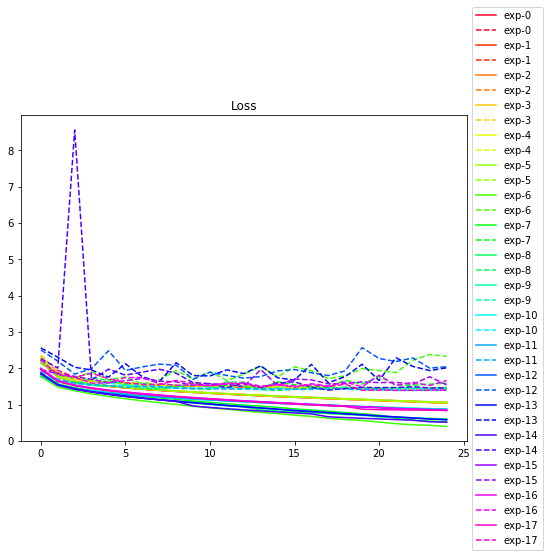

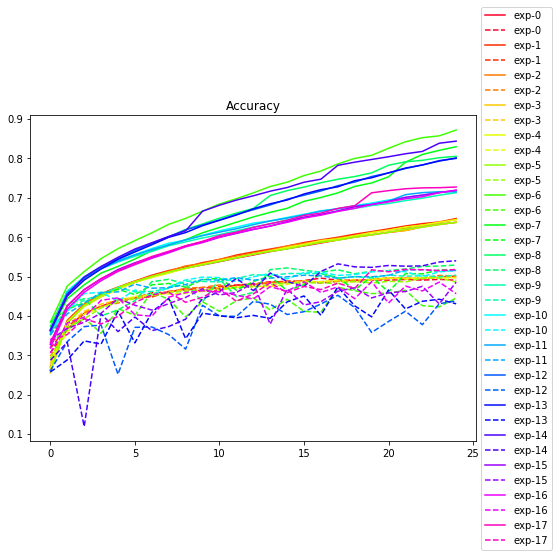

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()